# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-atfp2avl
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-atfp2avl
  Resolved https://github.com/albumentations-team/albumentations to commit 190ce313a143689e59ca727f799b729078a89285
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


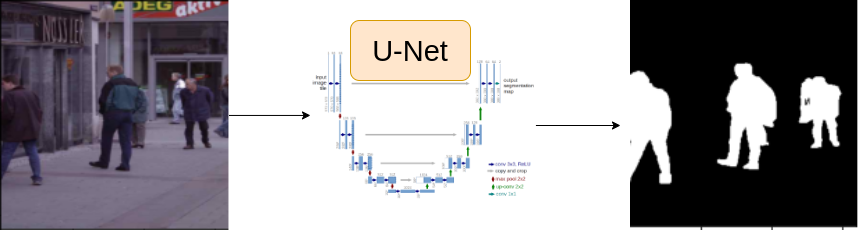

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_File = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR= '/content/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [ ]:
df= pd.read_csv(CSV_File)
df.head()


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row= df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) / 255.0

print(f"Image Shape : {image.shape}")
print(f"Mask Shape : {mask.shape}")

Image Shape : (183, 276, 3)
Mask Shape : (183, 276)


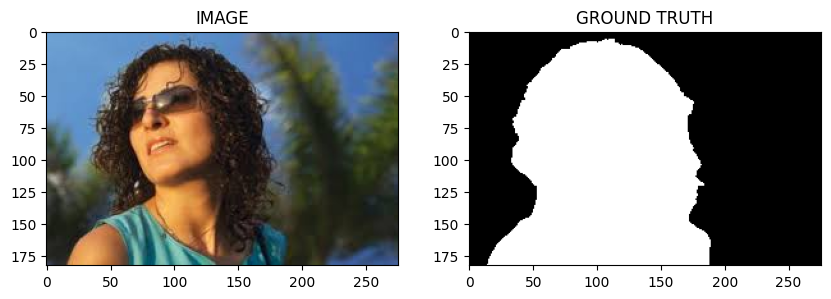

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df , valid_df = train_test_split(df , test_size= 0.2 , random_state= 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_aug():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],is_check_shapes=False)

def get_valid_aug():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),

  ],is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self , df , augmentations):
    self.df= df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path= row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image,mask=mask)
      image = data['image']
      mask = data['mask']

      image = np.transpose(image,(2,0,1)).astype(np.float32)
      mask = np.transpose(mask,(2,0,1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.Tensor(mask)  / 255.0

      return image,mask



In [ ]:
trainset=SegmentationDataset(train_df,get_train_aug())
validset = SegmentationDataset(valid_df,get_valid_aug())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


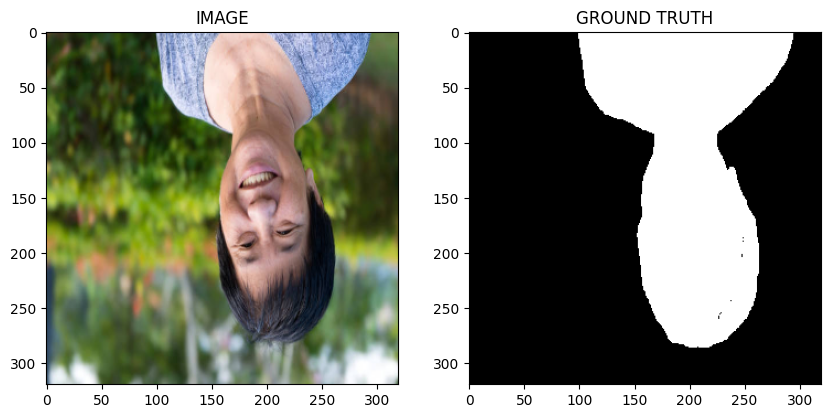

In [ ]:
idx = 3

image , mask = trainset[idx]
helper.show_image(image,mask)


# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader= DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader = DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [ ]:
for image , mask in trainloader:
  break
print(image.shape)
print(mask.shape)



torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    # ✅ FIXED: forward() is now correctly placed
    def forward(self, images, masks=None):
        logits = self.arc(images)

        if masks is not None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [ ]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss = 0.0

  for images,masks in data_loader:
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss/len(data_loader)



In [ ]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():


    for images,masks in data_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits,loss = model(images,masks)

        total_loss += loss.item()
    return total_loss/len(data_loader)




# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_valid_loss = np.inf

for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(),'best_model.pt')
    print("Saved Best Model!")

    print(f"Epoch : {i+1}")
  print(f"Train Loss : {train_loss:.4f}")
  print(f"Valid Loss : {valid_loss:.4f}")

Saved Best Model!
Epoch : 1
Train Loss : 0.7603
Valid Loss : 3.2370
Saved Best Model!
Epoch : 2
Train Loss : 0.3840
Valid Loss : 0.4208
Saved Best Model!
Epoch : 3
Train Loss : 0.3046
Valid Loss : 0.3397
Saved Best Model!
Epoch : 4
Train Loss : 0.2511
Valid Loss : 0.3376
Saved Best Model!
Epoch : 5
Train Loss : 0.2585
Valid Loss : 0.2978
Saved Best Model!
Epoch : 6
Train Loss : 0.2619
Valid Loss : 0.2573
Saved Best Model!
Epoch : 7
Train Loss : 0.2186
Valid Loss : 0.2537
Saved Best Model!
Epoch : 8
Train Loss : 0.2037
Valid Loss : 0.2244
Train Loss : 0.1865
Valid Loss : 0.2343
Saved Best Model!
Epoch : 10
Train Loss : 0.1871
Valid Loss : 0.2103
Saved Best Model!
Epoch : 11
Train Loss : 0.1353
Valid Loss : 0.1921
Train Loss : 0.1393
Valid Loss : 0.2184
Train Loss : 0.1282
Valid Loss : 0.2402
Train Loss : 0.1285
Valid Loss : 0.2503
Train Loss : 0.1482
Valid Loss : 0.2351
Train Loss : 0.1254
Valid Loss : 0.1936
Saved Best Model!
Epoch : 17
Train Loss : 0.1175
Valid Loss : 0.1754
Train Los

# Task 9 : Inference

In [ ]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image , mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask= torch .sigmoid (logits_mask)
pred_mask = (pred_mask > 0.5)*1.0


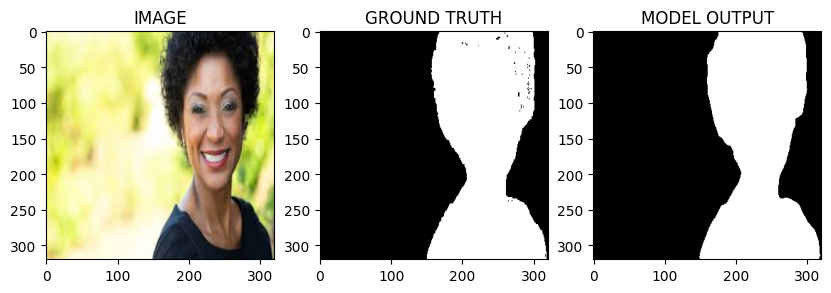

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))